<a href="https://colab.research.google.com/github/dharmesh312/Ai-Project---Myocardial-Infarction-using-CNN-interplretebility/blob/master/build_train_validate_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


drive/  sample_data/


In [2]:
cd "drive/My Drive/cnnIMI"

/content/drive/My Drive/cnnIMI


In [3]:
!pip install wfdb==1.3.9


    100% |████████████████████████████████| 92kB 3.4MB/s 
  Stored in directory: /root/.cache/pip/wheels/df/2e/5d/2dd99023aedd0f7839c2a51f51ff9c4ddc33b8efad2decee24
Successfully built wfdb


In [4]:
import numpy as np
import os
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import random
import glob
import wfdb
import pandas as pd
from sklearn.model_selection import KFold
from keras.layers import Input,Flatten, Convolution1D,BatchNormalization,Dense,Input,Dropout,MaxPool1D,GlobalAvgPool1D,\
AveragePooling1D,concatenate,Activation
from keras.models import Model
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint
from keras import backend as K
from keras.backend.tensorflow_backend import clear_session
from keras.regularizers import L1L2

Using TensorFlow backend.


# Utility functions

In [0]:
def calculate_scores(prob,y_true,verbose=1):
    y_pred=[]
    for pb in prob:
        if np.argmax(pb)==0:
            y_pred.append(np.array([1,0]))
        if np.argmax(pb)==1:
            y_pred.append(np.array([0,1]))
    y_pred=np.array(y_pred)
    
    accuracy=np.sum(y_pred[:,0]==y_true[:,0])/y_true.shape[0]
    tp=0
    fp=0
    tn=0
    fn=0
    for y_p,y_t in zip(y_pred,y_true): 
        if y_p[1]==1 and y_t[1]==1:
            tp=tp+1
        if y_p[1]==1 and y_t[1]==0:
            fp=fp+1
        if y_p[1]==0 and y_t[1]==0:
            tn=tn+1
        if y_p[1]==0 and y_t[1]==1:
            fn=fn+1
    if (tp+fn)==0:
        sensitivity='nan'
    else:
        sensitivity=tp/(tp+fn)
    if (tn+fp)==0:    
        specificity='nan'
    else:
        specificity=tn/(tn+fp)
    scores={'accuracy':accuracy,'sensitivity':sensitivity,'specificity':specificity}
    if verbose:
        print('accuracy: {}\t sensitivity: {}\t specificity: {}'.format\
              (accuracy,sensitivity,specificity))
    return scores

def get_patient_data(ind_train,ind_test,patients):
    patients=np.array(patients)
    patient_train=patients[ind_train]
    patient_test=patients[ind_test]
    X_train=[]
    X_test=[]
    X_train1=[]
    X_test1=[]
    X_train2=[]
    X_test2=[]
    X_train3=[]
    X_test3=[]
    
    y_train=[]
    y_test=[]
    for patient in patient_train:
        patient_keys=[key for key in data_dict.keys() if patient in key]
        for key in patient_keys:
            segments,label_bin=data_dict[key]
            X_train1=X_train1+list(np.reshape(segments[:,0,:],[segments.shape[0],segments.shape[2],1]))
            X_train2=X_train2+list(np.reshape(segments[:,1,:],[segments.shape[0],segments.shape[2],1]))
            X_train3=X_train3+list(np.reshape(segments[:,2,:],[segments.shape[0],segments.shape[2],1]))
            y_train=y_train+list(np.tile(label_bin,[segments.shape[0],1]))
            
                     
    X_train1=np.array(X_train1)    
    X_train2=np.array(X_train2)    
    X_train3=np.array(X_train3)    
    y_train=np.array(y_train)    
    
    for patient in patient_test:
        patient_keys=[key for key in data_dict.keys() if patient in key]
        for key in patient_keys:
            segments,label_bin=data_dict[key]
            X_test1=X_test1+list(np.reshape(segments[:,0,:],[segments.shape[0],segments.shape[2],1]))
            X_test2=X_test2+list(np.reshape(segments[:,1,:],[segments.shape[0],segments.shape[2],1]))
            X_test3=X_test3+list(np.reshape(segments[:,2,:],[segments.shape[0],segments.shape[2],1]))
            y_test=y_test+list(np.tile(label_bin,[segments.shape[0],1]))
    X_test1=np.array(X_test1)    
    X_test2=np.array(X_test2)    
    X_test3=np.array(X_test3)    
    y_test=np.array(y_test)    
    
    X_train=[X_train1,X_train2,X_train3]
    X_test=[X_test1,X_test2,X_test3]
    
    return X_train,y_train,X_test,y_test  

# Load ECG samples

In [0]:
data_dict=pickle.load(open(os.path.join('.','data','imi_hc_64Hz_3_lead.bin'),'rb'))

# Train-Test split based on patients

In [7]:
patients=np.array(list(set([ key.split('/')[-2] for key in list(data_dict.keys())])))
kfold_patient= KFold(n_splits=len(patients),shuffle=False)
print (patients[:5])

['patient241' 'patient117' 'patient139' 'patient116' 'patient011']


# Model

In [8]:
def conv_bn(filters,kernel_size,input_layer):
    x=Convolution1D(filters=filters,kernel_size=kernel_size,padding='same',
                    kernel_regularizer=None)(input_layer) 
    x=BatchNormalization()(x)
    x=Activation('relu')(x)
    x=MaxPool1D(pool_size=2)(x)
    return x

def inception_block(input_layer):
    conv3=conv_bn(4,3,input_layer)
    conv5=conv_bn(4,5,input_layer)
    conv7=conv_bn(4,7,input_layer)
    conv9=conv_bn(4,9,input_layer)
    conv16=conv_bn(4,16,input_layer)  
    conv32=conv_bn(4,32,input_layer)
    conv64=conv_bn(4,64,input_layer)
    return concatenate([conv3,conv5,conv7,conv9,conv16,conv32,conv64])

def get_model(input_shape):
    input_layer1= Input(shape=input_shape)      
    block1_ch1=inception_block(input_layer1)
    
#     input_layer2= Input(shape=input_shape)      
#     block1_ch2=inception_block(input_layer2)
    
#     input_layer3= Input(shape=input_shape)      
#     block1_ch3=inception_block(input_layer3)
    
#     x=concatenate([block1_ch1,block1_ch3,block1_ch3])
#     x=GlobalAvgPool1D()(x)
    x=GlobalAvgPool1D()(block1_ch1)
    output_layer=Dense(2,activation='softmax',kernel_regularizer=L1L2(l1=0.0,l2=0.001))(x)
    
#     model_paper=Model(inputs=[input_layer1,input_layer2,input_layer3],outputs=output_layer)
    model_paper=Model(inputs=input_layer1,outputs=output_layer)

    model_paper.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')
    return model_paper
model=get_model([196,1])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 196, 1)       0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 196, 4)       16          input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 196, 4)       24          input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, 196, 4)       32          input_1[0][0]                    
_____________________________________

In [9]:
for layer in model.layers:
  print(layer.get_config(), layer.get_weights())

{'batch_input_shape': (None, 196, 1), 'dtype': 'float32', 'sparse': False, 'name': 'input_1'} []
{'name': 'conv1d_1', 'trainable': True, 'filters': 4, 'kernel_size': (3,), 'strides': (1,), 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': (1,), 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None} [array([[[ 0.55221504,  0.46105927, -0.59896857, -0.23048317]],

       [[-0.46311116,  0.36635643, -0.31647143,  0.4228564 ]],

       [[ 0.4712965 ,  0.02077013,  0.0205723 , -0.5460321 ]]],
      dtype=float32), array([0., 0., 0., 0.], dtype=float32)]
{'name': 'conv1d_2', 'trainable': True, 'filters': 4, 'kernel_size': (5,), 'strides': (1,), 'padding':

# Train and Validate

In [10]:
count = 0
for ind_train,ind_test in kfold_patient.split(X=patients,y=[0]*len(patients)):
  count = count +1
print (count)  

82


In [11]:
import matplotlib.gridspec as gridspec

cvscores=[]
i=0

def genrateAllEcg(X_test,y_test):
    fig = plt.figure(figsize=(20,250))
    gs1 = gridspec.GridSpec(len(y_test), 1)
#     countries = ["Country " + str(i) for i in range(1, 26)]
    axs = []
    for c, num in zip(X_test[0],range(0,len(y_test))):
      axs.append(fig.add_subplot(gs1[num - 1]))
      axs[-1].plot(X_test[0][num])
      if y_test[num][0] == 1:
        axs[-1].set_xlabel("MC")
      else:
        axs[-1].set_xlabel("healthy")
    plt.show()

for ind_train,ind_test in kfold_patient.split(X=patients,y=[0]*len(patients)): 
    i=i+1        
    print ("iteration number ", i ," out of 82")
    X_train,y_train,X_test,y_test=get_patient_data(ind_train,ind_test,patients)

#     genrateAllEcg(X_test,y_test)  
    if i == 45:
      break
    model_paper=get_model(X_train[0].shape[1:])
    K.set_value(model_paper.optimizer.lr,1e-3)
    
    model_paper.fit(
        x=X_train[0],
        y=y_train,
        batch_size=32,
        epochs=200,
        shuffle=True,
        validation_data=(X_test[0],y_test),
        verbose=1,
        callbacks=[
            EarlyStopping(monitor='loss',min_delta=0.0,patience=10,verbose=1),
            ReduceLROnPlateau(min_lr=1e-5,factor=.1,monitor='loss',epsilon=0.0001,patience=5,verbose=1,),
        ]
    )

    prob = model_paper.predict(X_test[0])
    scores=calculate_scores(prob,y_test)
    cvscores.append(scores)
    print (cvscores)
    break
    clear_session()
    

iteration number  1  out of 82
Instructions for updating:
Use tf.cast instead.


/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:1065: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


Train on 6207 samples, validate on 70 samples
Epoch 1/200
6207/6207 [==============================] - 9s 1ms/step - loss: 0.5330 - acc: 0.7329 - val_loss: 0.0736 - val_acc: 1.0000
Epoch 2/200
6207/6207 [==============================] - 4s 650us/step - loss: 0.4697 - acc: 0.7801 - val_loss: 0.0864 - val_acc: 1.0000
Epoch 3/200
6207/6207 [==============================] - 4s 659us/step - loss: 0.4445 - acc: 0.7959 - val_loss: 0.1445 - val_acc: 1.0000
Epoch 4/200
6207/6207 [==============================] - 4s 651us/step - loss: 0.4331 - acc: 0.8046 - val_loss: 0.1155 - val_acc: 1.0000
Epoch 5/200
6207/6207 [==============================] - 4s 649us/step - loss: 0.4172 - acc: 0.8247 - val_loss: 0.1045 - val_acc: 1.0000
Epoch 6/200
6207/6207 [==============================] - 4s 642us/step - loss: 0.4077 - acc: 0.8323 - val_loss: 0.1018 - val_acc: 1.0000
Epoch 7/200
6207/6207 [==============================] - 4s 649us/step - loss: 0.3965 - acc: 0.8389 - val_loss: 0.0886 - val_acc: 1.00

In [15]:
model_paper.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 196, 1)       0                                            
__________________________________________________________________________________________________
conv1d_8 (Conv1D)               (None, 196, 4)       16          input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_9 (Conv1D)               (None, 196, 4)       24          input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_10 (Conv1D)              (None, 196, 4)       32          input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_11 

In [12]:
!pip install seaborn

70
predicted top1 class: 0


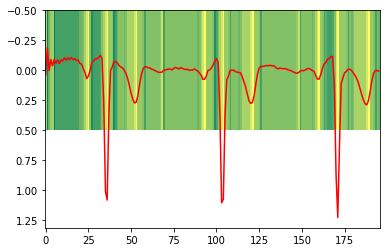

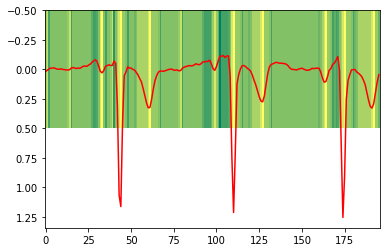

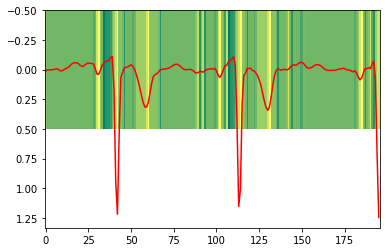

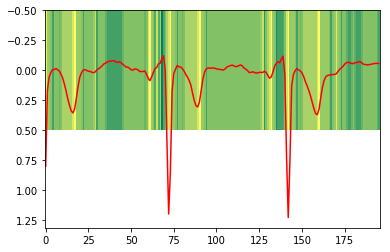

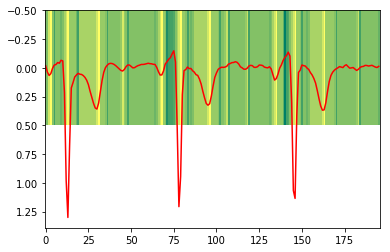

In [21]:
import keras
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input, decode_predictions
from keras.preprocessing import image
import keras.backend as K
from mpl_toolkits.axes_grid1 import make_axes_locatable

import tensorflow as tf
from tensorflow.python.framework import ops

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import pandas as pd
from matplotlib import cm




def register_gradient():
    if "GuidedBackProp" not in ops._gradient_registry._registry:
        @ops.RegisterGradient("GuidedBackProp")
        def _GuidedBackProp(op, grad):
            dtype = op.inputs[0].dtype
            return grad * tf.cast(grad > 0., dtype) * \
                tf.cast(op.inputs[0] > 0., dtype)


def modify_backprop(model, name):
    g = tf.get_default_graph()
    with g.gradient_override_map({'Relu': name}):

        # get layers that have an activation
        layer_dict = [layer for layer in model.layers[1:]
                      if hasattr(layer, 'activation')]

        # replace relu activation
        for layer in layer_dict:
            if layer.activation == keras.activations.relu:
                layer.activation = tf.nn.relu

        # re-instanciate a new model
#         new_model = VGG16(weights='imagenet')
    return model


def guided_backpropagation(img_tensor, model, activation_layer):
    model_input = model.input
    layer_output = model.get_layer(activation_layer).output

    max_output = K.max(layer_output, axis=2)

    get_output = K.function([model_input], [K.gradients(max_output, model_input)[0]])
    saliency = get_output([img_tensor])

    return saliency[0]


if __name__ == "__main__":
    
    img = X_test[0]               #load_image(path=img_path, target_size=(img_width, img_height))

    print (len(X_test[0]))
    preds = model.predict(img)
    predicted_class = preds.argmax(axis=1)[0]
    # decode the results into a list of tuples (class, description, probability)
    # (one such list for each sample in the batch)
    print("predicted top1 class:", predicted_class)


    register_gradient()
    guided_model = modify_backprop(model_paper, 'GuidedBackProp')
    gradient = guided_backpropagation(X_test[0], guided_model, "conv1d_8")
#     print (len(gradient))
    for i in range(len(gradient[:5])):
      df = pd.DataFrame( (np.array( list(itertools.chain.from_iterable(gradient[i])) )) )
      plt.imshow( df.transpose( ), cmap=cm.summer, interpolation='nearest', vmin=min(gradient[i]), vmax=max(gradient[i]),aspect = 'auto' )
      plt.plot(X_test[0][i] , color="red")
      plt.show(  )


kernels of layer named :  conv1d_22/kernel:0 	 Size of the kernel is :  3


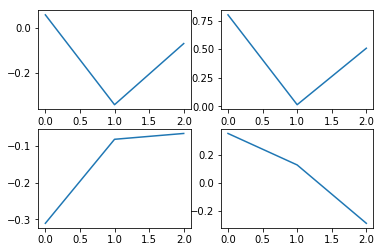



kernels of layer named :  conv1d_23/kernel:0 	 Size of the kernel is :  5


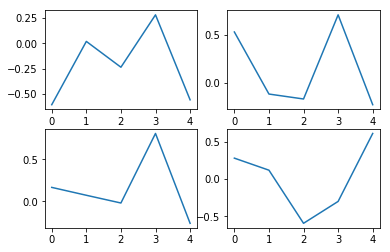



kernels of layer named :  conv1d_24/kernel:0 	 Size of the kernel is :  7


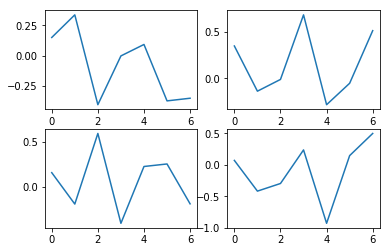



kernels of layer named :  conv1d_25/kernel:0 	 Size of the kernel is :  9


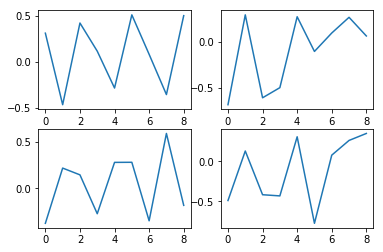



kernels of layer named :  conv1d_26/kernel:0 	 Size of the kernel is :  16


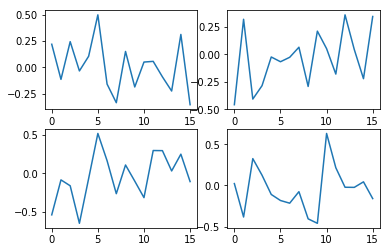



kernels of layer named :  conv1d_27/kernel:0 	 Size of the kernel is :  32


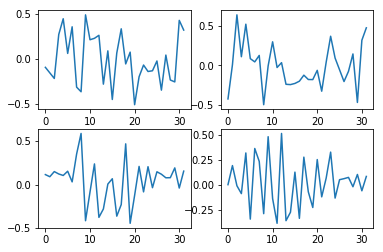



kernels of layer named :  conv1d_28/kernel:0 	 Size of the kernel is :  64


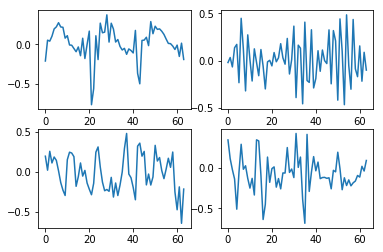



kernels of layer named :  conv1d_29/kernel:0 	 Size of the kernel is :  3


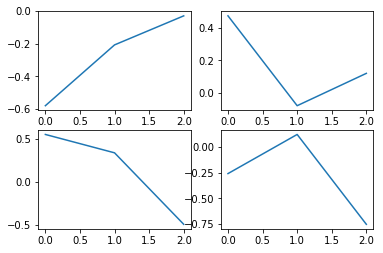



kernels of layer named :  conv1d_30/kernel:0 	 Size of the kernel is :  5


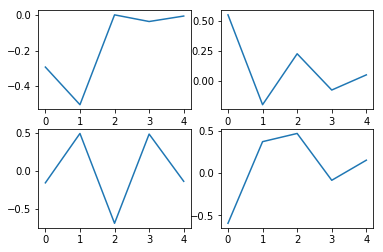



kernels of layer named :  conv1d_31/kernel:0 	 Size of the kernel is :  7


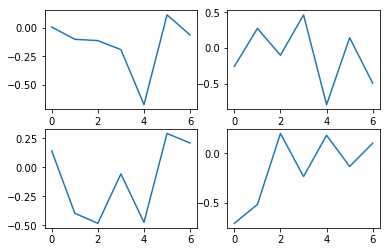



kernels of layer named :  conv1d_32/kernel:0 	 Size of the kernel is :  9


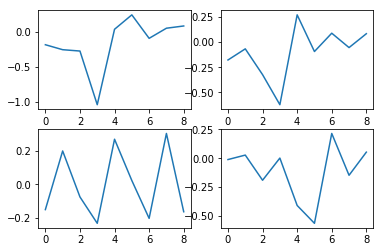



kernels of layer named :  conv1d_33/kernel:0 	 Size of the kernel is :  16


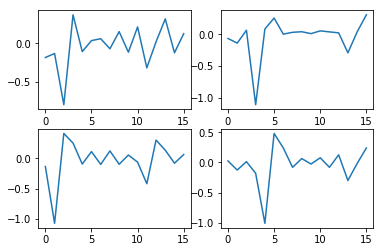



kernels of layer named :  conv1d_34/kernel:0 	 Size of the kernel is :  32


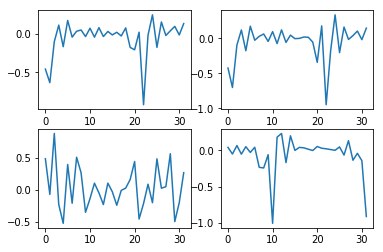



kernels of layer named :  conv1d_35/kernel:0 	 Size of the kernel is :  64


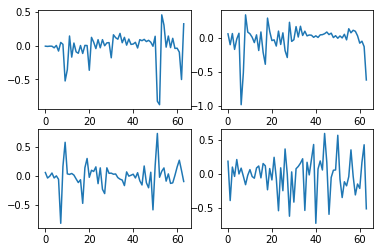



kernels of layer named :  conv1d_36/kernel:0 	 Size of the kernel is :  3


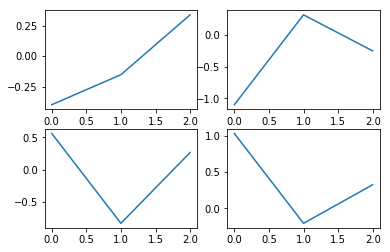



kernels of layer named :  conv1d_37/kernel:0 	 Size of the kernel is :  5


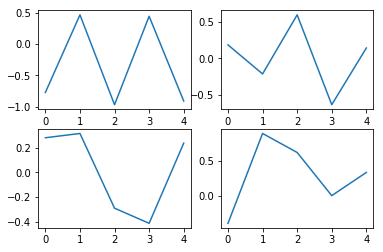



kernels of layer named :  conv1d_38/kernel:0 	 Size of the kernel is :  7


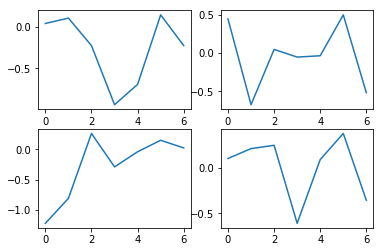



kernels of layer named :  conv1d_39/kernel:0 	 Size of the kernel is :  9


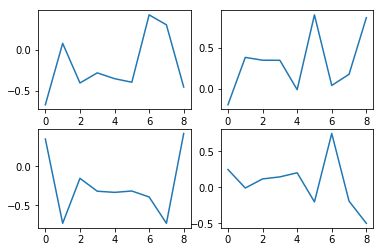



kernels of layer named :  conv1d_40/kernel:0 	 Size of the kernel is :  16


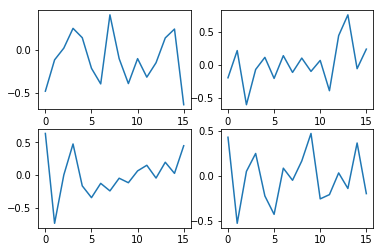



kernels of layer named :  conv1d_41/kernel:0 	 Size of the kernel is :  32


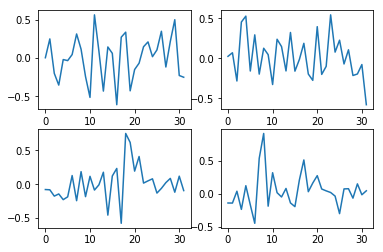



kernels of layer named :  conv1d_42/kernel:0 	 Size of the kernel is :  64


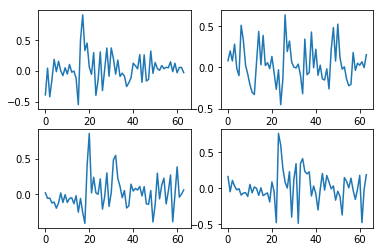

In [0]:
names = [weight.name for layer in model_paper.layers for weight in layer.weights]
weights = model_paper.get_weights()

for name, weight in zip(names, weights):
    if "conv" in name and "kernel" in name:
      
      transposedKernels = np.transpose(weight)
      print ("kernels of layer named : " , name , "\t Size of the kernel is : ", len(transposedKernels[0][0]))
      for i in range(len(transposedKernels)):
        plt.subplot(2,2, i +1)
        plt.plot(transposedKernels[i][0])
      plt.show()
      print ("\n")

# Calculate Average Scores

In [0]:
sensitivity=[]
specificity=[]
accuracy=[]

for score in cvscores:
    if score['sensitivity']!='nan':
        sensitivity.append(score['sensitivity'])
    if score['specificity']!='nan':
        specificity.append(score['specificity'])
    accuracy.append(score['accuracy'])

np.mean(np.array(accuracy)),np.mean(np.array(sensitivity)),np.mean(np.array(specificity))